In [61]:
import numpy as np
from pyscf import gto, scf, ao2mo
from pyscf.fci import direct_spin1

# 1. 分子定義とRHF計算
mol = gto.M(atom='H 0 0 0; H 0 0 0.7414', basis='sto-3g', unit='A', verbose=0)
mf = scf.RHF(mol).run()

# 2. 積分をMO基底に変換 (ここはどうしても必要です)
h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff
eri = ao2mo.kernel(mol, mf.mo_coeff)

# 3. 行列の一括取得 (ここが簡略化ポイント)
# pspace関数は、通常「エネルギーの低い重要な配置」だけを選びますが、
# np(抽出数)を十分大きくすれば、全配置のハミルトニアン行列を返します。
norb, nelec = mf.mo_coeff.shape[1], mol.nelec
addr, H_mat = direct_spin1.pspace(h1, eri, norb, nelec, np=1000)

print("FCI Hamiltonian Shape:", H_mat.shape)
print("\n--- Electronic Hamiltonian Matrix ---")
print(np.array_str(H_mat, precision=4, suppress_small=True))

# 固有値確認
e, _ = np.linalg.eigh(H_mat)
print(f"\nGround State Energy: {e[0] + mol.energy_nuc():.8f} Hartree")

FCI Hamiltonian Shape: (4, 4)

--- Electronic Hamiltonian Matrix ---
[[-1.8304  0.      0.      0.1813]
 [ 0.     -1.0649  0.1813  0.    ]
 [ 0.      0.1813 -1.0649  0.    ]
 [ 0.1813  0.      0.     -0.2545]]

Ground State Energy: -1.13727017 Hartree


ChatGPTで生成したコード（ちゃんと動かない）

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, fci

# ===============================
# 1. Build H2 STO-3G Hamiltonian
# ===============================
mol = gto.Mole()
mol.atom = "H 0 0 0; H 0 0 0.74"
mol.basis = "sto-3g"
mol.build()

mf = scf.RHF(mol).run()

cisolver = fci.FCI(mf)
H_mat = cisolver.kernel(return_matrix=True)[1]

dim = H_mat.shape[0]
print("Number of determinants:", dim)
print("FCI matrix:\n", H_mat)

# ==================================
# 2. FCIQMC Simulation (Booth 2009)
# ==================================
n_steps = 10
delta_tau = 0.003
target_population = 1000

# Shift parameter (population control)
shift = 0.0
shift_update_rate = 0.01  # α in the paper

# Walker population vector (signed integer)
walkers = np.zeros(dim, dtype=float)

# Start with random walker on HF determinant (index 0)
walkers[0] = 10

population_history = []
energy_estimates = []

rng = np.random.default_rng()

for step in range(n_steps):

    new_walkers = np.zeros(dim)

    for i in range(dim):
        n_i = int(abs(walkers[i]))
        sign_i = np.sign(walkers[i])
        if n_i == 0:
            continue

        # --------- Spawning (off-diagonal hopping) ---------
        for _ in range(n_i):
            # randomly choose connected determinant j
            j = rng.integers(0, dim)

            if j != i and H_mat[j, i] != 0:
                prob = abs(H_mat[j, i]) * delta_tau

                if rng.random() < prob:
                    sign = np.sign(H_mat[j, i]) * sign_i
                    new_walkers[j] += sign

        # --------- Death/Cloning (diagonal contribution) ---------
        diag_term = (H_mat[i, i] - shift)
        death_prob = diag_term * delta_tau

        for _ in range(n_i):
            if rng.random() < death_prob:
                walkers[i] -= sign_i
            else:
                walkers[i] += sign_i

    walkers += new_walkers

    # --------- Annihilation ---------
    walkers = np.round(walkers)  # clean fractional walkers
    for i in range(dim):
        if abs(walkers[i]) < 1:
            walkers[i] = 0

    # --------- Population Control ---------
    total_pop = np.sum(abs(walkers))
    shift += shift_update_rate * np.log(total_pop / target_population)

    # --------- Energy Estimator (Projected) ---------
    if walkers[0] != 0:
        E_proj = H_mat[0] @ walkers / walkers[0]
        energy_estimates.append(E_proj)

    population_history.append(total_pop)

# ================================
# Output Results
# ================================
print("\n==== FCIQMC Result ====")
print("Mean projected energy:", np.mean(energy_estimates[-2000:]))
print("Exact FCI energy:", cisolver.kernel()[0])


converged SCF energy = -1.11675930739642
Number of determinants: 2
FCI matrix:
 [[ 9.93646755e-01  1.38777878e-16]
 [ 8.45112964e-17 -1.12543887e-01]]

==== FCIQMC Result ====
Mean projected energy: 0.9936467548998384
Exact FCI energy: -1.137283834488502


## 2025/11/27 生成
プロンプト: ではあらためてこの論文に基づいて、H2 STO-3Gの系の基底エネルギーを求めるFCIQMCのpythonコードを生成してください。projected energyとshiftをプロットするコードもつけてください。

walker数が急激に増えすぎてstep数を少し増やすだけで動かなくなる

converged SCF energy = -1.11675930739642
Exact FCI energy = -1.137283834488502


/var/folders/0t/tdldxsbs797_z7ws58l5kg1r0000gn/T/ipykernel_97287/3321812838.py:146: RuntimeWarning: divide by zero encountered in log
  shift -= (gamma / delta_tau) * np.log(Nw / N_target)


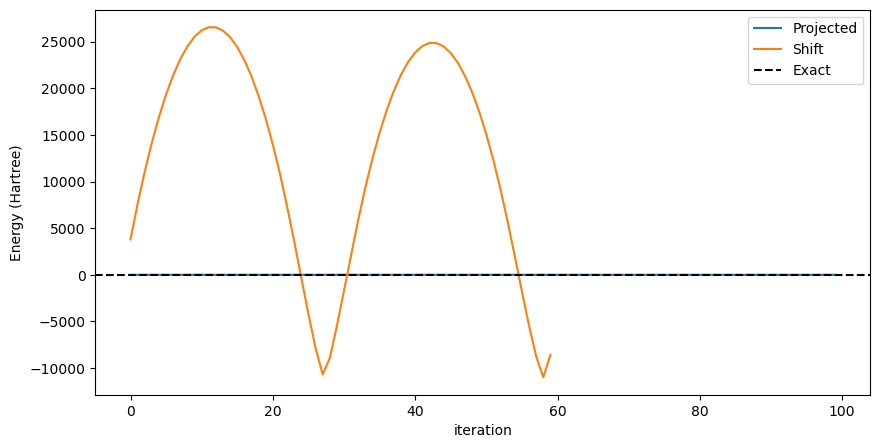

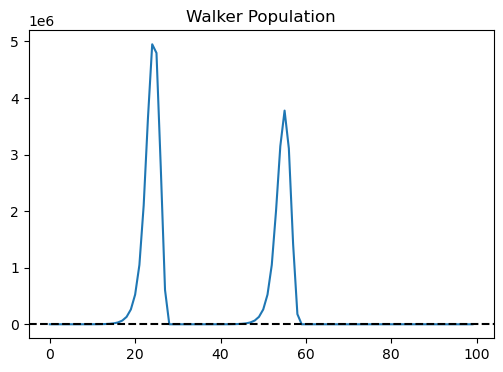

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo, fci


# =======================================================
# 1. H2 Hamiltonian（PySCF v2 compatible）
# =======================================================

mol = gto.M(
    atom="H 0 0 0; H 0 0 0.74",
    basis="sto-3g",
    unit="Angstrom",
    spin=0
)

mf = scf.RHF(mol).run()

# One-electron
h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff

# Two-electron
eri_ao = mol.intor("int2e")
eri = ao2mo.restore(1, ao2mo.incore.full(eri_ao, mf.mo_coeff), mf.mo_coeff.shape[1])

# FCI Hamiltonian
nmo = mf.mo_coeff.shape[1]
cisolver = fci.FCI(mol, mf.mo_coeff)
E_fci, H_fci = cisolver.kernel(h1, eri, nmo, mol.nelec, return_matrix=True)
print("Exact FCI energy =", E_fci)

dim = H_fci.shape[0]


# =======================================================
# 2. FCIQMC Parameters
# =======================================================

walkers = {0: [1]}   # HF に +1 walker から開始
shift = -0.5         # ←非常に重要：最初は負から開始

delta_tau = 0.0001   # ←H2ではこのくらいが安定（めちゃ重要）
gamma = 0.05
N_target = 2000

n_steps = 100


# =======================================================
# Helpers
# =======================================================

def total_walkers(w):
    return sum(len(v) for v in w.values())

def project_energy(w, H):
    C = np.zeros(dim)
    for i, lst in w.items():
        C[i] = np.sum(lst)
    if C[0] == 0:
        return 0
    return np.dot(H[:, 0], C) / C[0]


# =======================================================
# 3. FCIQMC Loop（安定版）
# =======================================================

rng = np.random.default_rng()
proj_hist, shift_hist, pop_hist = [], [], []

for step in range(n_steps):

    # spawn buffer
    spawn_pos = {}
    spawn_neg = {}

    # -------------------------------
    # spawn step（均等サンプル）
    # -------------------------------
    for i, lst in walkers.items():
        for sign_i in lst:
            j = rng.integers(0, dim)
            p_gen = 1.0 / dim
            Hij = H_fci[j, i]
            P = abs(Hij) * delta_tau / p_gen
            if P > 1:
                P = 1

            if rng.random() < P:
                s = np.sign(Hij) * sign_i
                if s > 0:
                    spawn_pos.setdefault(j, []).append(1)
                else:
                    spawn_neg.setdefault(j, []).append(-1)

    # -------------------------------
    # death / clone step（正しく）
    # -------------------------------
    new_walkers = {}
    for i, lst in walkers.items():
        new_list = []
        Hii = H_fci[i, i]
        P = (Hii - shift) * delta_tau

        for sign_i in lst:
            if P > 0:
                # death
                if rng.random() >= P:
                    new_list.append(sign_i)
            else:
                # keep original
                new_list.append(sign_i)
                # clone
                if rng.random() < -P:
                    new_list.append(sign_i)

        if len(new_list) > 0:
            new_walkers[i] = new_list

    walkers = new_walkers

    # -------------------------------
    # spawn の追加
    # -------------------------------
    for j, lst in spawn_pos.items():
        walkers.setdefault(j, []).extend(lst)
    for j, lst in spawn_neg.items():
        walkers.setdefault(j, []).extend(lst)

    # -------------------------------
    # annihilation（高速・正確）
    # -------------------------------
    for i, lst in list(walkers.items()):
        total = np.sum(lst)
        if total == 0:
            del walkers[i]
        else:
            # +N or -N にまとめる
            walkers[i] = [1] * total if total > 0 else [-1] * (-total)

    # -------------------------------
    # shift update（population control）
    # -------------------------------
    Nw = total_walkers(walkers)
    shift -= (gamma / delta_tau) * np.log(Nw / N_target)

    # logs
    proj_hist.append(project_energy(walkers, H_fci))
    shift_hist.append(shift)
    pop_hist.append(Nw)


# =======================================================
# 4. Plot
# =======================================================

plt.figure(figsize=(10,5))
plt.plot(proj_hist, label="Projected")
plt.plot(shift_hist, label="Shift")
plt.axhline(E_fci, color="k", ls="--", label="Exact")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("Energy (Hartree)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(pop_hist)
plt.axhline(N_target, color="k", ls="--")
plt.title("Walker Population")
plt.show()


## 2025/11/27 生成
プロンプト: どうもうまく行かないですね。そしたらH2とは別の系で比較的シンプルなもののFCIQMCのコードを生成してもらえますか？

実際の系ではなく、適当なハミルトニアンを与えて計算。結局振動してうまく収束しない。

Exact energy: -1.2403124237432848


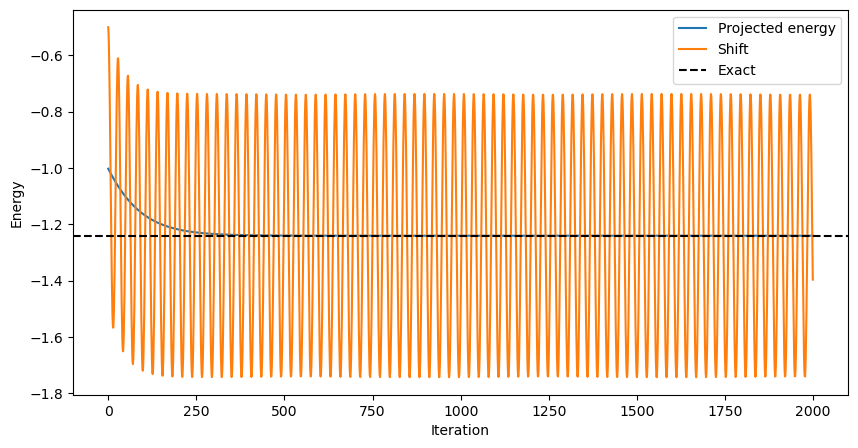

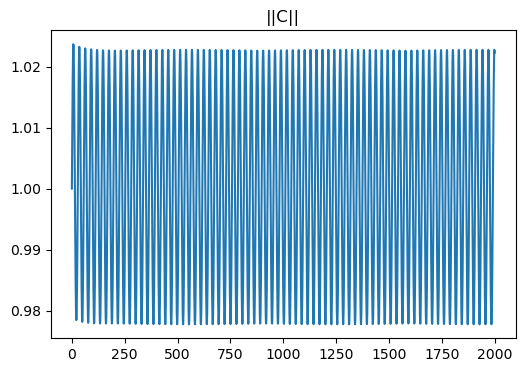

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# =======================================================
# 1. テスト用の最も簡単な 2×2 ハミルトニアン
# =======================================================

H = np.array([
    [-1.0, -0.5],
    [-0.5, -0.2]
])

# 正解固有値
eigvals, eigvecs = np.linalg.eigh(H)
E_exact = eigvals[0]
print("Exact energy:", E_exact)

dim = 2


# =======================================================
# 2. det-FCIQMC 初期条件
# =======================================================

# CIベクトル（実数）
C = np.array([1.0, 0.0])  # HF基底として0番に集中

shift = -0.5

delta_tau = 0.01
gamma = 0.05
N_target = 1.0  # det-FCIQMCではCIノルムの目標

n_steps = 2000

proj_hist = []
shift_hist = []
norm_hist = []


# =======================================================
# 3. projected energy
# =======================================================
def projected_energy(C):
    if C[0] == 0:
        return 0
    return (H[:,0] @ C) / C[0]


# =======================================================
# 4. det-FCIQMC メインループ
# =======================================================

for step in range(n_steps):

    # population control via shift
    normC = np.linalg.norm(C)
    shift -= (gamma / delta_tau) * np.log(normC / N_target)

    # deterministic evolution
    K = H - shift * np.eye(dim)

    C = C - delta_tau * (K @ C)

    # normalization (optional but stable)
    # C /= np.linalg.norm(C)

    proj = projected_energy(C)

    proj_hist.append(proj)
    shift_hist.append(shift)
    norm_hist.append(normC)


# =======================================================
# 5. Plot
# =======================================================

plt.figure(figsize=(10,5))
plt.plot(proj_hist, label="Projected energy")
plt.plot(shift_hist, label="Shift")
plt.axhline(E_exact, color='k', ls='--', label='Exact')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(norm_hist)
plt.title("||C||")
plt.show()
